## Titanic 泰坦尼克号预测

基本思路为:
1. 导入数据集
2. 对数据预处理
3. 训练
4. 预测并输出结果

In [3]:
# 提前将所有包引入
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import activations
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
import datetime

#### 1.导入数据 load_data

In [4]:
# 导入数据
def load_data(path_url, test_path_url):
    raw_train_dataset = pd.read_csv(path_url)
    raw_test_dataset = pd.read_csv(test_path_url)
    return raw_train_dataset, raw_test_dataset

测试

In [5]:
# 1. 导入数据
path_url = r"kaggle\titanic\train.csv"
test_path_url = r"kaggle\titanic\test.csv"
raw_train_dataset, raw_test_dataset = load_data(path_url, test_path_url)
print(f"raw_train_dataset.shape={raw_train_dataset.shape}")
print(f"raw_test_dataset.shape={raw_test_dataset.shape}")

raw_train_dataset.shape=(891, 12)
raw_test_dataset.shape=(418, 11)


#### 2.数据预处理 preprocess

In [6]:
# 数据预处理的基础方法
def preprocess(raw_dataset, features, train=True):
    """用于predict的数据预处理
    Args:
        input: dataset = pandas.DataFrame对象
    """
    # 以中位数来替代
    if "Age" in features:
        raw_dataset["Age"].fillna(raw_dataset["Age"].median(), inplace=True)
    raw_dataset["Fare"].fillna(raw_dataset["Fare"].median(), inplace=True)
    raw_dataset["Embarked"].fillna(raw_dataset["Fare"].median(), inplace=True)
    dataset = raw_dataset[features]
    dataset = dataset.copy()

    # 由于 embarked=登船港口, Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

    Embarked = dataset.pop("Embarked")

    # 根据 embarked 列来写入新的 3 个列
    dataset["S"] = (Embarked == "S") * 1.0
    dataset["C"] = (Embarked == "C") * 1.0
    dataset["Q"] = (Embarked == "Q") * 1.0

    # 根据 sex 列来写入新的 2 个列
    Sex = dataset.pop("Sex")
    dataset["Male"] = (Sex == "male") * 1.0
    dataset["Female"] = (Sex == "female") * 1.0

    dataset_withoutna = dataset
    if train:
        labels = dataset_withoutna["Survived"]
        dataset_withoutna.pop("PassengerId")
        dataset_withoutna.pop("Survived")
        # 标准化,归一化输入
        train_stats = dataset_withoutna.describe()
        train_stats = train_stats.transpose()
        normed_train_data = (dataset_withoutna - train_stats["mean"]) / train_stats[
            "std"
        ]
        return np.array(normed_train_data), np.array(labels)
    else:
        labels = dataset.pop("PassengerId")
        dataset.fillna(0, inplace=True)
        test_stats = dataset.describe()
        test_stats = test_stats.transpose()
        normed_test_data = (dataset - test_stats["mean"]) / test_stats["std"]
        return np.array(normed_test_data), np.array(labels)

测试

In [7]:
    # 2. 数据预处理
    features_test = [
        "PassengerId",
        "Pclass",
        "Sex",
        "Fare",
        "Age",
        "SibSp",
        "Parch",
        "Embarked",
    ]
    features_train = features_test + ["Survived"]

    # 获取预处理后的训练集和标签
    train_dataset, labels = preprocess(raw_train_dataset, features_train)
    print(f"train_dataset.shape={train_dataset.shape}")
    print(f"labels.shape={labels.shape}")

train_dataset.shape=(891, 10)
labels.shape=(891,)


#### 3.训练 train

In [8]:
def train(train_dataset, labels, epochs=120, batch_size=512, is_plot=False):
    model = tf.keras.Sequential(
        [
            # 1. input_shape = 输入形状
            # ND 张量的形状：. 最常见的情况是带有 shape 的 2D 输入。
            # (batch_size, ..., input_dim)(batch_size, input_dim)
            # train_dataset.shape[1] = 4
            # 现在模型就会以尺寸为 (*, 4) 的数组作为输入，
            # 2. kernel_regularizer = 应用于kernel权重矩阵的正则化函数。
            # 𝐿2正则化：范数的平方
            tf.keras.layers.Dense(
                64,
                activation="relu",
                input_shape=(train_dataset.shape[1],),
                kernel_regularizer=regularizers.l2(0.001),
            ),
            tf.keras.layers.Dense(
                32, activation="relu", kernel_regularizer=regularizers.l2(0.001)
            ),
            tf.keras.layers.Dense(16, activation="relu"),
            tf.keras.layers.Dense(1, name="prediction"),
        ]
    )

    # 在 Keras 中提供了 compile()和 fit()函数方便实现逻辑。
    # compile：首先通过compile 函数指定网络使用的优化器对象、损失函数类型，评价指标等设定，这一步称为装配
    # fit： 模型装配完成后，即可通过 fit()函数送入待训练的数据集和验证用的数据集
    model.compile(
        # Adam的学习律默认为0.001
        optimizer=tf.keras.optimizers.Adam(),
        # BinaryCrossentropy:计算真实标签和预测标签之间的交叉熵损失
        # i.e, value in [-inf, inf] when from_logits=True
        # i.e, value in [0., 1.] when from_logits=False
        # from_logits=False：
        # 当from_logits = True时，网络预测值y_pred必须为还没经过Softmax、sigmoid等函数的变量；
        # 当from_logits=False时，网络预测值y_pred是经过概率化后的值。
        # 当 from_logits 设置为 True 时，y_pred 表示须为未经过 Softmax 函数的变量 z；
        # 当 from_logits 设置为 False 时，y_pred 表示为经过 Softmax 函数的输出。
        # 为了数值计算稳定性，一般设置 from_logits 为 True，
        # 此时tf.keras.losses.categorical_crossentropy 将在内部进行 Softmax 函数计算，
        # 所以不需要在模型中显式调用 Softmax 函数
        # 这样 categorical_crossentropy 函数在计算损失函数前，会先内部调用 Softmax 函数
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        # 设置测量指标为准确率
        metrics=["accuracy"],
    )

    # early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    # 模型装配完成后，即可通过 fit()函数送入待训练的数据集和验证用的数据集，这一步称为模型训练
    # fit函数的参数:
    # x = Input data
    # y = Target data
    # verbose = 'auto'、0、1 或 2 详细模式。
    # 0 = 静音，1 = 进度条，2 = 每个 epoch 一行。'auto' 在大多数情况下默认为 1
    history = model.fit(
        x=train_dataset,
        y=labels,
        epochs=epochs,
        validation_split=0.01,
        batch_size=batch_size,
        verbose="auto",
        # callbacks=[early_stop]
    )

    # 显示训练情况
    if is_plot:
        plot_history(history)

    # 可以通过 Model.evaluate(db)循环测试完 db 数据集上所有样本
    loss, accuracy = model.evaluate(train_dataset, labels, verbose=2)
    print("Accuracy:", accuracy)

    return model

显示训练情况 plot_history

In [9]:
# 显示训练情况
def plot_history(history):
    # histoty的返回值
    # A History object. Its History.history attribute is a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable).
    # 一个历史对象。它的 History.history 属性是连续 epoch 的训练损失值和指标值的记录，
    # 以及验证损失值和验证指标值（如果适用）。
    # history.history：loss、accuracy、val loss、val accuracy
    hist = pd.DataFrame(history.history)
    hist["epoch"] = history.epoch

    plt.figure()
    plt.xlabel("Num of Epochs")
    plt.ylabel("value")
    # plt.plot(hist["epoch"], hist["loss"], label="Loss")
    # plt.plot(hist["epoch"], hist["val_loss"], label="val_loss")
    plt.plot(hist["epoch"], hist["accuracy"], label="accuracy")
    plt.plot(hist["epoch"], hist["val_accuracy"], label="val_accuracy")
    plt.ylim([0, 1])
    plt.legend()
    plt.show()

测试

Epoch 1/256
2/2 [==============================] - 1s 165ms/step - loss: 0.7458 - accuracy: 0.6111 - val_loss: 0.7122 - val_accuracy: 0.7778
Epoch 2/256
2/2 [==============================] - 0s 25ms/step - loss: 0.7279 - accuracy: 0.6122 - val_loss: 0.7000 - val_accuracy: 0.7778
Epoch 3/256
2/2 [==============================] - 0s 26ms/step - loss: 0.7108 - accuracy: 0.6134 - val_loss: 0.6884 - val_accuracy: 0.7778
Epoch 4/256
2/2 [==============================] - 0s 25ms/step - loss: 0.6954 - accuracy: 0.6145 - val_loss: 0.6780 - val_accuracy: 0.7778
Epoch 5/256
2/2 [==============================] - 0s 23ms/step - loss: 0.6809 - accuracy: 0.6145 - val_loss: 0.6682 - val_accuracy: 0.7778
Epoch 6/256
2/2 [==============================] - 0s 23ms/step - loss: 0.6664 - accuracy: 0.6156 - val_loss: 0.6591 - val_accuracy: 0.7778
Epoch 7/256
2/2 [==============================] - 0s 28ms/step - loss: 0.6527 - accuracy: 0.6202 - val_loss: 0.6502 - val_accuracy: 0.8889
Epoch 8/256
2/2 [==

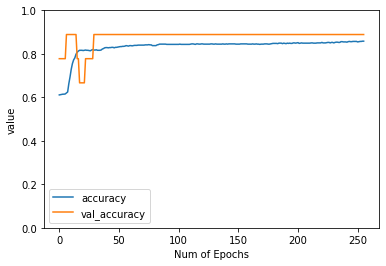

28/28 - 0s - loss: 0.3576 - accuracy: 0.8586 - 34ms/epoch - 1ms/step
Accuracy: 0.8585858345031738


In [10]:
 # 3. 训练
model = train(train_dataset, labels, epochs=256, is_plot=True)

#### 4.真实预测并输出csv predict_out

In [11]:
# 真实预测并输出csv
def predict_out(model, csv_path):
    # model.evaluate 和 model.predict 的区别
    # https://blog.csdn.net/DoReAGON/article/details/88552348
    # 两者差异：
    # 1
    # 输入输出不同
    # model.evaluate输入数据(data)和金标准(label),然后将预测结果与金标准相比较,得到两者误差并输出.
    # model.predict输入数据(data),输出预测结果
    # 2
    # 是否需要真实标签(金标准)
    # model.evaluate需要,因为需要比较预测结果与真实标签的误差
    # model.predict不需要,只是单纯输出预测结果,全程不需要金标准的参与.
    predictions = model.predict(test_dataset)
    # 通过astype()方法可以强制转换数据的类型。
    predictions = (tf.sigmoid(predictions).numpy().flatten() > 0.5).astype(int)
    print(predictions.shape, predictions)
    # 输出结果
    output = pd.DataFrame({"PassengerId": passenger_id, "Survived": predictions})
    # index=False 不保存行索引,index=是否保留行索引
    output.to_csv(csv_path, index=False)
    print(f"您的提交文件保存成功! 位置在{csv_path}")
    return predictions

获取年月日时分秒 get_time

在输出预测结果csv的时候附上时间，方便区别。


In [13]:
# 获取年月日时分秒
def get_time():
    return datetime.datetime.now().strftime("%Y%m%d%H%M")

测试

In [16]:
# 获取预处理后的测试集和序号
test_dataset, passenger_id = preprocess(
    raw_test_dataset, features_test, train=False
)

csv_path = f"./submission_{get_time()}.csv"
prediction = predict_out(model, csv_path)

14/14 [==============================] - 0s 925us/step
(418,) [0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0
 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0
 0 1 1 1 1 0 0 1 0 0 0]
您的提交文件保存成功! 位置在./submission_202208181521.csv


#### 5.主函数

In [ ]:
# 1. 导入数据
path_url = r"kaggle\titanic\train.csv"
test_path_url = r"kaggle\titanic\test.csv"

raw_train_dataset, raw_test_dataset = load_data(path_url, test_path_url)

# 2. 数据预处理
features_test = [
    "PassengerId",
    "Pclass",
    "Sex",
    "Fare",
    "Age",
    "SibSp",
    "Parch",
    "Embarked",
]
features_train = features_test + ["Survived"]

# 获取预处理后的训练集和标签
train_dataset, labels = preprocess(raw_train_dataset, features_train)

# 3. 训练
model = train(train_dataset, labels, epochs=256, is_plot=True)

# 获取预处理后的测试集和序号
test_dataset, passenger_id = preprocess(
    raw_test_dataset, features_test, train=False
)

csv_path = f"./submission_{get_time()}.csv"
prediction = predict_out(model, csv_path)

# 验证与原始数据raw_test_dataset长度是否一致
if prediction.shape[0] == raw_test_dataset.shape[0]:
    print(f"--预测长度={prediction.shape[0]}校验通过 √")
else:
    print(
        f"--预测长度与raw_test_dataset长度不一致 ×,prediction.shape={prediction.shape},raw_test_dataset.shape={raw_test_dataset.shape}"
    )